In [1]:
library(ggplot2)
library(data.table)
library(dplyr)
library(tidyr)
library(purrr) 
library(scales)
if (!require(extrafont)) install.packages("extrafont")
library(extrafont)

# 3. 폰트 로드
loadfonts()

Warning message:
“패키지 ‘ggplot2’는 R 버전 4.3.3에서 작성되었습니다”
Warning message:
“패키지 ‘dplyr’는 R 버전 4.3.3에서 작성되었습니다”

다음의 패키지를 부착합니다: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“패키지 ‘tidyr’는 R 버전 4.3.3에서 작성되었습니다”
Warning message:
“패키지 ‘purrr’는 R 버전 4.3.3에서 작성되었습니다”

다음의 패키지를 부착합니다: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose


Warning message:
“패키지 ‘scales’는 R 버전 4.3.3에서 작성되었습니다”

다음의 패키지를 부착합니다: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


필요한 패키지를 로딩중입니다: extrafont

Registering fonts with R



In [2]:
cohort <- "simulation" 

# Load data

In [3]:
# 방법 1: paste0() 사용
frreg_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/", 
    cohort, 
    "/obj1/slope-test"
)

# .slope 파일 리스트 불러오기
files_list <- list.files(
    path = frreg_path, 
    pattern = "\\.slope$",  
    full.names = TRUE
) %>% 
    # .raw.slope 파일 제외
    .[!grepl("\\.raw\\.slope$", .)]

length(files_list)

[1] 7290

In [4]:
# 모든 .slope 파일 읽고 원하는 형태로 가공하기
df_combined <- files_list %>%
    # 각 파일을 읽어서 리스트로 만들기
    map(function(file) {
        # 파일명에서 pheno 이름 추출 (첫번째 '.' 이전까지의 문자열)
        pheno <- basename(file) %>%
            strsplit("\\.") %>%
            .[[1]] %>%
            .[1]
        
        # 파일 읽기
        df <- fread(file)
        
        # slope와 intercept의 median 값 추출
        slope_val <- df[param == "slope", median]
        intercept_val <- df[param == "intercept", median]
        
        # significant 판단
        slope_lower <- df[param == "slope", `lower(2.5%)`]
        slope_upper <- df[param == "slope", `upper(97.5%)`]
        
        significant <- case_when(
            slope_lower > 1 ~ "fast",
            slope_upper < 1 ~ "slow",
            TRUE ~ "similar"
        )
        
        # 데이터프레임 생성
        data.frame(
            pheno = pheno,
            slope = slope_val,
            intercept = intercept_val,
            significant = significant
        )
    }) %>%
    # 모든 데이터프레임 합치기
    bind_rows()

head(df_combined)

,pheno,slope,intercept,significant
,<chr>,<dbl>,<dbl>,<chr>
1,G_140-S_109-w_1152-e_10,0.4376302,-2.035210,slow
2,G_140-S_109-w_1152-e_5,0.4231007,-2.063328,slow
3,G_140-S_109-w_1152-e_50,0.2971038,-2.241941,similar
4,G_140-S_109-w_1178-e_10,0.4517030,-2.032238,slow
5,G_140-S_109-w_1178-e_5,0.4390127,-2.054435,slow
6,G_140-S_109-w_1178-e_50,0.4607094,-1.989773,similar


In [5]:
# true significant 값 추출 함수 수정
get_true_significant <- function(pheno) {
    w_value <- as.numeric(gsub(".*w_(\\d+).*", "\\1", pheno)) / 1000
    case_when(
        w_value < 1 ~ "increasing",
        w_value >= 1 & w_value < 1.8 ~ "slow",
        w_value >= 1.8 & w_value <= 2.2 ~ "similar",
        w_value > 2.2 ~ "fast",
        TRUE ~ NA_character_    # 예외 케이스 처리
    )
}

df_simul_combined <- df_combined %>%
    mutate(
        # 각 파라미터 값 추출 및 1000으로 나누기
        G = as.numeric(gsub(".*G_(\\d+).*", "\\1", pheno)) / 1000,
        S = as.numeric(gsub(".*S_(\\d+).*", "\\1", pheno)) / 1000,
        w = as.numeric(gsub(".*w_(\\d+).*", "\\1", pheno)) / 1000,
        e = as.numeric(gsub(".*e_(\\d+).*", "\\1", pheno)) / 1000,
        # 기존 true_significant 계산
        true_significant = sapply(pheno, get_true_significant),
        match_result = true_significant == significant
    ) %>%
    mutate(
        true_significant = factor(true_significant, 
                                levels = c("fast", "slow", "increasing", "similar")),
        significant = factor(significant, 
                           levels = c("fast", "slow", "increasing", "similar"))
    ) %>%
    filter(!is.na(slope), 
           !is.na(intercept),
           !is.na(true_significant),
           !is.na(significant))

# 결과 확인
head(df_simul_combined)

,pheno,slope,intercept,significant,G,S,w,e,true_significant,match_result
,<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
1,G_140-S_109-w_1152-e_10,0.4376302,-2.035210,slow,0.14,0.109,1.152,0.010,slow,TRUE
2,G_140-S_109-w_1152-e_5,0.4231007,-2.063328,slow,0.14,0.109,1.152,0.005,slow,TRUE
3,G_140-S_109-w_1152-e_50,0.2971038,-2.241941,similar,0.14,0.109,1.152,0.050,slow,FALSE
4,G_140-S_109-w_1178-e_10,0.4517030,-2.032238,slow,0.14,0.109,1.178,0.010,slow,TRUE
5,G_140-S_109-w_1178-e_5,0.4390127,-2.054435,slow,0.14,0.109,1.178,0.005,slow,TRUE
6,G_140-S_109-w_1178-e_50,0.4607094,-1.989773,similar,0.14,0.109,1.178,0.050,slow,FALSE


# plot matching ratio

- true = test mathcing rate (for w bin)

In [6]:
get_nature_theme <- function() {
    theme_bw() +
        theme(
            # 전체적인 배경
            panel.background = element_rect(fill = "white", color = "black", size = 0.5),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            
            # 축 설정
            axis.line = element_line(color = "black", size = 0.3),
            axis.text = element_text(size = 6.5, color = "black"),
            axis.title = element_text(size = 7.5, color = "black"),
            axis.ticks = element_line(size = 0.3),
            axis.ticks.length = unit(0.8, "mm"),
            
            # 범례 설정
            legend.background = element_rect(fill = "transparent", color = NA),
            legend.text = element_text(size = 5),
            legend.title = element_text(size = 5),
            legend.key.size = unit(0.5, "lines"),
            legend.key.height = unit(0.6, "lines"),
            legend.key.width = unit(0.3, "lines"),
            legend.position = "right",
            legend.box = "vertical",
            legend.margin = margin(0, 0, 0, 0),
            legend.spacing.y = unit(0.1, "cm"),
            
            # 여백 설정
            plot.margin = unit(c(0.1, 0.2, 0.1, 0.1), "cm")
        )
}

In [24]:
plot_matching_ratio <- function(data, use_ntile = FALSE) {
    # 데이터 전처리
    df_ratio <- data %>%
        group_by(e) %>%
        mutate(
            # use_ntile 파라미터에 따라 구간 나누기 방식 선택
            w_bin = if(use_ntile) ntile(w, n = 20) else cut(w, breaks = 20)
        ) %>%
        group_by(w_bin, e) %>%
        summarise(
            match_ratio = mean(match_result) * 100,
            w_mid = mean(w),
            .groups = 'drop'
        )
    
    # 플롯 생성
    p <- ggplot(df_ratio, aes(x = w_mid, y = match_ratio, color = factor(e))) +
        geom_line(size = 0.3) +
        geom_point(
            size = 1.5, 
            alpha = 0.8,
            stroke = 0.3
        ) +
        scale_color_brewer(
            palette = "Set2",
            guide = guide_legend(
                keywidth = unit(0.5, "lines"),
                keyheight = unit(0.5, "lines")
            )
        ) +
        labs(
            x = expression("Decay rate ("*w[s]*")"),
            y = "Agreement between\ntest and true decay pattern (%)",  # 새로운 y축 레이블
            color = "Error"
        ) +
        get_nature_theme() + 
        theme(
            strip.background = element_rect(
                fill = "white",
                color = "black",
                size = 0.5
            ),
            strip.text = element_text(
                size = 9,
                margin = margin(t = 2, b = 2)
            ),
            strip.placement = "outside"
        )
    
    return(p)
}

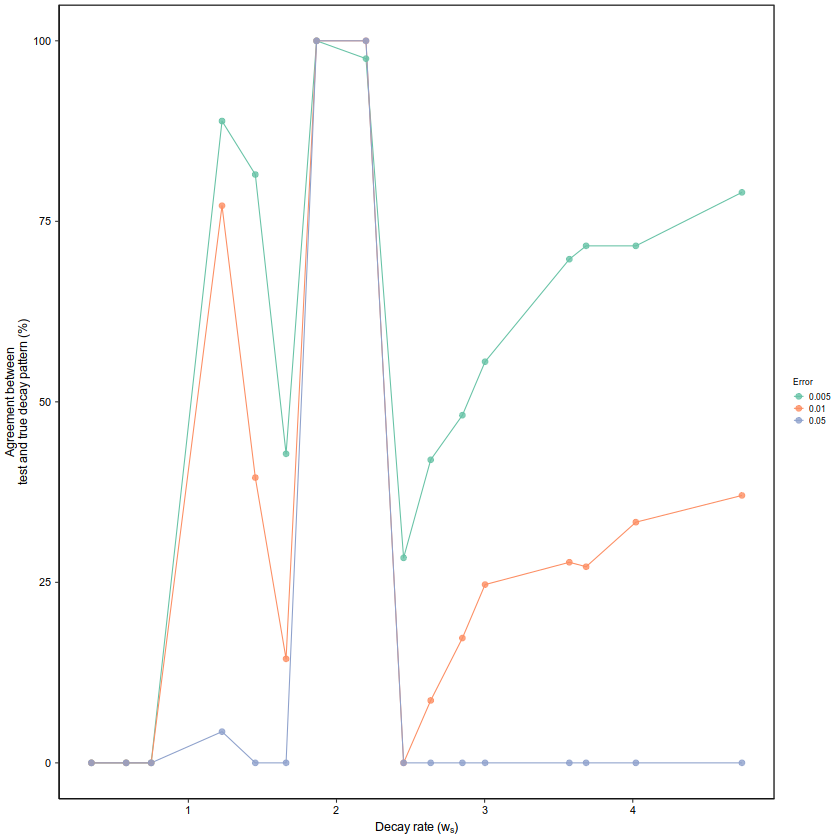

In [25]:
# 함수 사용 예시:
p <- plot_matching_ratio(
    data = df_simul_combined,
    use_ntile = FALSE  # cut() 사용
)
print(p)

# 파일 저장
output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    "simulation.slope-test.matching-ratio.pdf"
)

ggsave(
    filename = output_path,
    plot = p,
    width = 65,
    height = 48,
    units = "mm",
    dpi = 300
)

# plot slope test for various error level

In [29]:
plot_slope_intercept_comparison <- function(data) {
    # 데이터 정렬: similar를 마지막에 그리도록 순서 변경
    data <- data %>%
        arrange(desc(significant == "similar"))
    
    # shape 정의
    shape_values <- c(
        "fast" = 24,
        "slow" = 25,
        "similar" = 21,
        "increasing" = 22
    )

    color_values <- c(
        "fast" = "#E41A1C",    # 빨강
        "slow" = "#377EB8",    # 파랑
        "similar" = "#999999", # 회색
        "increasing" = "#4DAF4A"  # 초록
    )
    
    ggplot(data, aes(x = intercept, y = slope)) +
        geom_point(aes(shape = true_significant,
                      fill = significant,
                      color = NA),
                  size = 2,
                  stroke = 0.3,
                  alpha = 0.8) +
        scale_fill_manual(
            values = color_values,
            guide = guide_legend(
                override.aes = list(
                    shape = 21,
                    color = "white",
                    size = 2
                ),
                keywidth = unit(0.5, "lines"),
                keyheight = unit(0.5, "lines")
            )
        ) +
        scale_shape_manual(
            values = shape_values,
            guide = guide_legend(
                override.aes = list(
                    size = 2
                ),
                keywidth = unit(0.5, "lines"),
                keyheight = unit(0.5, "lines")
            )
        ) +
        scale_color_manual(values = c("black" = "black"),
                          guide = "none") +
        geom_hline(yintercept = 1, 
                   linetype = "dashed", 
                   color = "black", 
                   size = 0.2) +
        facet_wrap(~e, 
                #   labeller = label_bquote(epsilon == .(e)), 
                labeller = label_bquote(error == .(e)),
                  nrow = 1) +  # 한 줄에 모든 subplot 배치
        labs(
            x = "Intercept",
            y = "Slope",
            shape = "Decay (true)",
            fill = "Decay (test)"
        ) +
        # scale_x_continuous(limits = c(-3, 1)) +  # x축 범위 고정
        # scale_y_continuous(limits = c(0.2, 1.8)) +  # y축 범위 고정
        get_nature_theme() +
        theme(
            strip.background = element_blank(),  # facet 레이블 배경 제거
            strip.text = element_text(size = 8)  # facet 레이블 크기 조정
        ) + 
        theme(
            strip.background = element_rect(
                fill = "white",
                color = "black",
                size = 0.5
            ),
            strip.text = element_text(
                size = 9,
                margin = margin(t = 2, b = 2)
            ),
            strip.placement = "outside"
        )
}

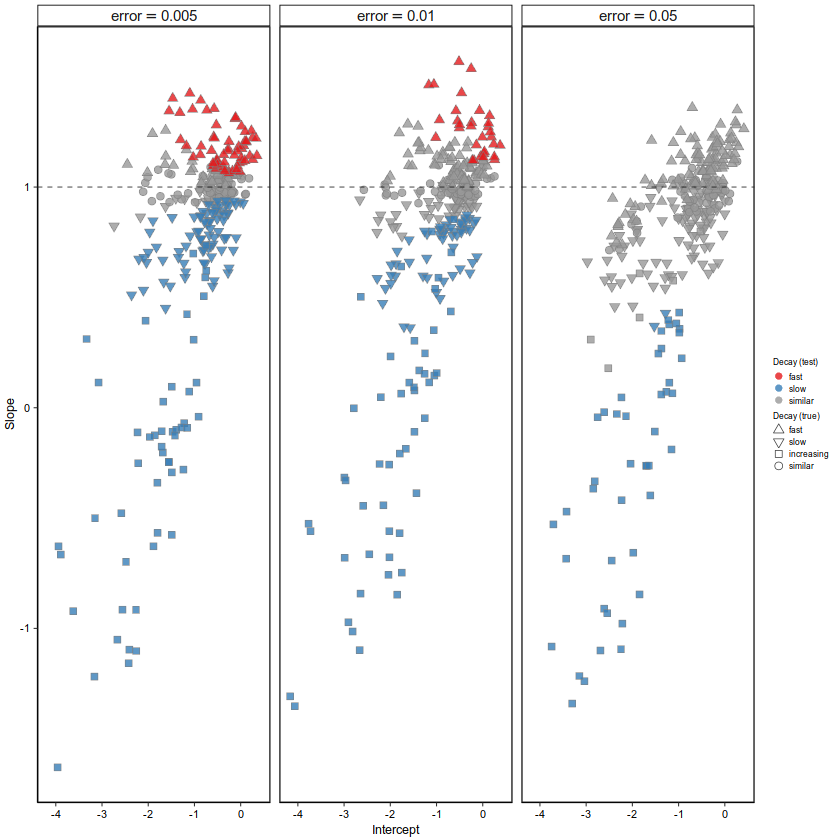

In [30]:
# 함수 사용 예시:
df_plot <- df_simul_combined %>%
    group_by(e) %>%
    group_modify(~ {
        bind_rows(
            .x %>% filter(true_significant == "slow") %>% sample_n(100),
            .x %>% filter(true_significant == "similar") %>% sample_n(50),
            .x %>% filter(true_significant == "fast") %>% sample_n(100),
            .x %>% filter(true_significant == "increasing") %>% sample_n(50)
        )
    }) %>%
    ungroup()

p <- plot_slope_intercept_comparison(df_plot)
print(p)

# 파일 저장
output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    "simulation.slope-test.varying-error.pdf"
)

ggsave(
    filename = output_path,
    plot = p,
    width = 108,
    height = 48,
    units = "mm",
    dpi = 300
)

In [16]:
df_simul_combined %>% 
    filter(slope < 0)

pheno,slope,intercept,significant,G,S,w,e,true_significant,match_result
<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
G_140-S_109-w_232-e_10,-1.75341160,-4.314364,slow,0.14,0.109,0.232,0.010,increasing,FALSE
G_140-S_109-w_232-e_5,-1.75157411,-4.306296,slow,0.14,0.109,0.232,0.005,increasing,FALSE
G_140-S_109-w_232-e_50,-1.77718888,-4.413358,slow,0.14,0.109,0.232,0.050,increasing,FALSE
G_140-S_109-w_297-e_10,-1.40084664,-3.946535,slow,0.14,0.109,0.297,0.010,increasing,FALSE
G_140-S_109-w_297-e_5,-1.39673058,-3.944041,slow,0.14,0.109,0.297,0.005,increasing,FALSE
G_140-S_109-w_297-e_50,-1.45338915,-4.108996,slow,0.14,0.109,0.297,0.050,increasing,FALSE
G_140-S_109-w_339-e_10,-1.20680847,-3.744739,slow,0.14,0.109,0.339,0.010,increasing,FALSE
G_140-S_109-w_339-e_5,-1.21274445,-3.758730,slow,0.14,0.109,0.339,0.005,increasing,FALSE
G_140-S_109-w_339-e_50,-1.22397862,-3.758857,slow,0.14,0.109,0.339,0.050,increasing,FALSE
